In [1]:
import random
import tensorflow as tf

2024-04-09 17:24:11.193086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 17:24:11.277865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 17:24:13.698601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 生成数据集

In [2]:
def synthetic_data(w, b, num_examples):
    """
    生成 y=Xw+b+噪声
    """
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1,1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1,1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tf.Tensor([-0.45433035  0.01986981], shape=(2,), dtype=float32) 
label: tf.Tensor([3.2225199], shape=(1,), dtype=float32)


In [4]:
import tensorflow_util as d2l

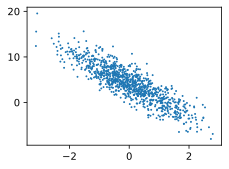

In [5]:
d2l.set_figsize()
# 查看第2个特征 features[:, 1] 和 labels 的散点图，观察这两者之间的线性关系
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 读取数据集

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [7]:
# 读取第一个小批量数据样本并打印
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[-0.11424123  1.0346316 ]
 [ 1.0604322   0.6689657 ]
 [ 0.1544022  -1.4744146 ]
 [ 0.79013133 -1.1103407 ]
 [ 0.9076354  -2.0434191 ]
 [ 1.0695157   0.211034  ]
 [ 0.3783142  -0.2872594 ]
 [-1.0407861   0.42102247]
 [ 0.5622863   1.5566006 ]
 [ 1.0432518   2.17349   ]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 0.44516525]
 [ 4.038631  ]
 [ 9.521614  ]
 [ 9.544754  ]
 [12.970637  ]
 [ 5.614635  ]
 [ 5.9196825 ]
 [ 0.6742597 ]
 [ 0.03892012]
 [-1.0968834 ]], shape=(10, 1), dtype=float32)


## 初始化模型参数

In [8]:
# 从 均值为0, 标准差为 0.01 的正态分布中采样随机数来初始化权重，并将偏置初始化为 0
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01), trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

## 定义模型

In [9]:
def linreg(X, w, b):
    """
    线性回归模型
    """
    return tf.matmul(X, w) + b

## 定义损失函数

In [10]:
def squared_loss(y_hat, y):
    """
    均方误差
    """
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

## 定义优化算法

In [11]:
def sgd(params, grads, lr, batch_size):
    """
    小批量随机梯度下降
    """
    for param, grad in zip(params, grads):
        # 原地更新模型参数的值
        param.assign_sub(lr * grad / batch_size)

## 训练

In [14]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # X 和 y 的小批量损失
        # 计算 l 关于 [w,b] 的梯度
        dw, db = g.gradient(l, [w, b])
        # 使用参数的梯度更新参数
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_sum(train_l)):f}')

epoch 1, loss 0.048840
epoch 2, loss 0.048854
epoch 3, loss 0.048929
epoch 4, loss 0.048830
epoch 5, loss 0.048846


In [15]:
print(f'w的估计误差: {true_w - tf.reshape(w, true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: [-4.5633316e-04 -2.9087067e-05]
b的估计误差: [-0.00061989]


In [16]:
w, b

(<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 2.0004563],
        [-3.399971 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.2006197], dtype=float32)>)